# Gaussian Naive Bayesian alogorithm
https://scikit-learn.org/stable/modules/naive_bayes.html

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix, classification_report

from sklearn.pipeline import Pipeline, make_pipeline
import scikitplot as skplt
# 모델저장
from joblib import dump, load

## 1. Probability density function이 우도(likelihood)

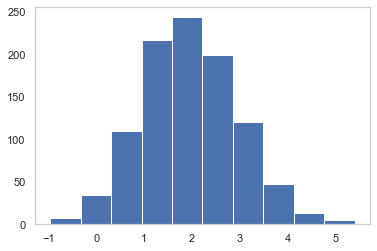

In [2]:
sns.set_style("whitegrid", {'axes.grid' : False})
mu_A, sigma_A = 2, 1
ax = plt.hist(np.random.normal(mu_A, sigma_A, size=(1000)))

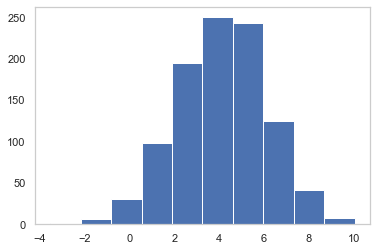

In [3]:
mu_B, sigma_B = 4, 2
ax = plt.hist(np.random.normal(mu_B, sigma_B, size=(1000)))

In [4]:
import scipy
scipy.stats.norm(mu_A, sigma_A).pdf(2) # '2'를 관측하였을 경우 A분포의 우도
scipy.stats.norm(mu_B, sigma_B).pdf(2) # '2'를 관측하였을 경우 B분포의 우도

0.3989422804014327

0.12098536225957168

### 2. MAP (Maximum A posterio)
https://en.wikipedia.org/wiki/Naive_Bayes_classifier

In [5]:
df = pd.DataFrame({'성별' : ['남성', '남성', '남성', '남성','여성','여성','여성','여성'],
                  '신장' : [6, 5.92, 5.58, 5.92, 5, 5.5, 5.42, 5.75], # feet
                  '무게' : [180, 190, 170, 165, 100, 150, 130, 150],  # pounds
                  '발의크기' : [12, 11, 12, 10, 6, 8, 7, 9]})             # inches
data = df.groupby('성별')['신장', '무게', '발의크기'].agg(['mean','var']).reset_index('성별')
df = df.merge(data, on='성별')
df = df.append({'신장':6, '무게':130, '발의크기':8}, ignore_index=True)
df

,성별,신장,무게,발의크기,"(신장, mean)","(신장, var)","(무게, mean)","(무게, var)","(발의크기, mean)","(발의크기, var)"
0,남성,6.00,180.0,12.0,5.8550,0.035033,176.25,122.916667,11.25,0.916667
1,남성,5.92,190.0,11.0,5.8550,0.035033,176.25,122.916667,11.25,0.916667
2,남성,5.58,170.0,12.0,5.8550,0.035033,176.25,122.916667,11.25,0.916667
3,남성,5.92,165.0,10.0,5.8550,0.035033,176.25,122.916667,11.25,0.916667
4,여성,5.00,100.0,6.0,5.4175,0.097225,132.50,558.333333,7.50,1.666667
5,여성,5.50,150.0,8.0,5.4175,0.097225,132.50,558.333333,7.50,1.666667
6,여성,5.42,130.0,7.0,5.4175,0.097225,132.50,558.333333,7.50,1.666667
7,여성,5.75,150.0,9.0,5.4175,0.097225,132.50,558.333333,7.50,1.666667
8,NaN,6.00,130.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data
mu_m, sigma_m = data.iloc[0,1], np.sqrt(data.iloc[0,2]); (mu_m, sigma_m**2)
mu_f, sigma_f = data.iloc[1,1], np.sqrt(data.iloc[1,2]); (mu_f, sigma_f**2)

성별      신장                무게               발의크기          
         mean       var    mean         var   mean       var
0  남성  5.8550  0.035033  176.25  122.916667  11.25  0.916667
1  여성  5.4175  0.097225  132.50  558.333333   7.50  1.666667

(5.855, 0.0350333333333333)

(5.4175, 0.09722499999999992)

### 신장(height), 단일변수만 고려할 경우는 남성일 가능성(사후확률)이 높다

In [7]:
like_m = scipy.stats.norm(mu_m, sigma_m).pdf(6)
print('남성 우도는 {0:.3f}이고, 남성일 사후확률은 {1:.2f}'.format(like_m,0.5*like_m))
like_f = scipy.stats.norm(mu_f, sigma_f).pdf(6)
print('여성 우도는 {0:.3f}이고, 여성일 사후확률은 {1:.2f}'.format(like_f,0.5*like_f))

남성 우도는 1.579이고, 남성일 사후확률은 0.79
여성 우도는 0.223이고, 여성일 사후확률은 0.11


Text(6.0, 1.5788831832641042, '     Likelihood of 6 feet')

Text(0.5, 1.0, '키가 6피트인 사람이 남성일 가능성(Likelihood)')

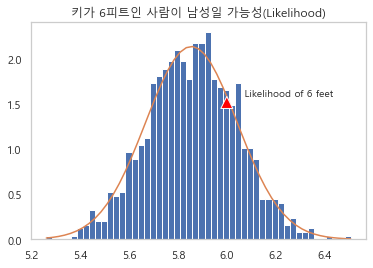

In [8]:
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
s = np.random.normal(mu_m, sigma_m, 1000)
fig, ax = plt.subplots()
n, bins, ignored = ax.hist(s, 50, density=1) # 50 bins
ax.annotate('     Likelihood of 6 feet', xy=(6., like_m), arrowprops=dict(facecolor='red'))
plt.plot(bins, 1/(sigma_m * np.sqrt(2 * np.pi))* np.exp(- (bins - mu_m)**2 / (2*sigma_m**2)))
plt.title('키가 6피트인 사람이 남성일 가능성(Likelihood)')

Text(6.0, 0.2234587268448157, '  Likelihood of 6 feet')

Text(0.5, 1.0, '키가 6피트인 사람이 여성일 가능성(Likelihood)')

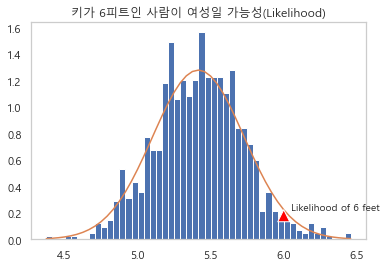

In [9]:
s = np.random.normal(mu_f, sigma_f, 1000)
fig, ax = plt.subplots()
n, bins, ignored = ax.hist(s, 50, density=1) # 50 bins
ax.annotate('  Likelihood of 6 feet', xy=(6., like_f), arrowprops=dict(facecolor='red'))
plt.plot(bins, 1/(sigma_f * np.sqrt(2 * np.pi))* np.exp(- (bins - mu_f)**2 / (2*sigma_f**2)))
plt.title('키가 6피트인 사람이 여성일 가능성(Likelihood)')

### 신장(height), 체중, 발크기 등 다변량을 고려할 경우는 여성일 가능성(사후확률)이 높다

In [10]:
import math
mh= ((1/math.sqrt(2*math.pi*data.iloc[0,2])) * 
     math.exp(-1*(6 - data.iloc[0,1])**2/(2*data.iloc[0,2])))
mw= ((1/math.sqrt(2*math.pi*data.iloc[0,4])) * 
     math.exp(-1*(130 - data.iloc[0,3])**2/(2*data.iloc[0,4])))
mf=((1/math.sqrt(2*math.pi*data.iloc[0,6])) * 
    math.exp(-1*(8 - data.iloc[0,5])**2/(2*data.iloc[0,6])))
print('남성일 사후확률 {0:.5f}'.format(mh* mw* mf*0.5))

wh= ((1/math.sqrt(2*math.pi*data.iloc[1,2])) * 
     math.exp(-1*(6 - data.iloc[1,1])**2/(2*data.iloc[1,2])))
ww= ((1/math.sqrt(2*math.pi*data.iloc[1,4])) * 
     math.exp(-1*(130 - data.iloc[1,3])**2/(2*data.iloc[1,4])))
wf=((1/math.sqrt(2*math.pi*data.iloc[1,6])) * 
    math.exp(-1*(8 - data.iloc[1,5])**2/(2*data.iloc[1,6])))
print('여성일 사후확률 {0:.5f}'.format(wh* ww* wf*0.5))

남성일 사후확률 0.00000
여성일 사후확률 0.00054


## 3. Gaussian Naive Bayes

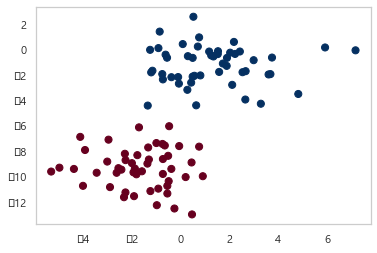

In [11]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

In [12]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

In [13]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(5000, 2)
Xnew

array([[ 1.68338905, -1.12659141],
       [ 2.43868727, -4.19210271],
       [-0.06883281, -2.37390596],
       ...,
       [ 4.29703127, -4.09195724],
       [-0.43988133, -0.34826863],
       [-5.66697602,  0.64435144]])

### 의사결정경계선이 곡선으로 나타나고 예측 확률은 '0', '1'에 편중하여 생성

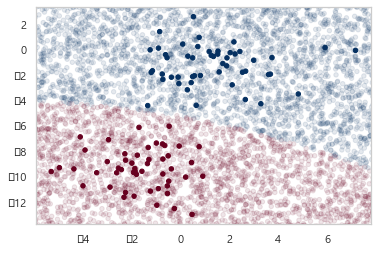

In [14]:
ynew= model.predict(Xnew)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

(array([2086.,   66.,   37.,   35.,   42.,   32.,   44.,   43.,   66.,
        2549.]),
 array([3.0043337e-16, 1.0000000e-01, 2.0000000e-01, 3.0000000e-01,
        4.0000000e-01, 5.0000000e-01, 6.0000000e-01, 7.0000000e-01,
        8.0000000e-01, 9.0000000e-01, 1.0000000e+00]),
 <BarContainer object of 10 artists>)

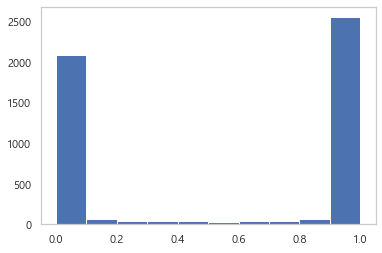

In [15]:
yprob = model.predict_proba(Xnew)
plt.hist(yprob[:, 1])

## 4. Text mining

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
corpus
df = pd.DataFrame(corpus, columns=['content'])
df

['This is the first document.',
 'This document is the second document.',
 'And this is the third one.',
 'Is this the first document?']

,content
0,This is the first document.
1,This document is the second document.
2,And this is the third one.
3,Is this the first document?


In [17]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus) # X = vectorizer.fit_transform(df['content'])
print(vectorizer.get_feature_names())

print(X.toarray())

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [18]:
data = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
data

,and,document,first,is,one,second,the,third,this
0,0,1,1,1,0,0,1,0,1
1,0,2,0,1,0,1,1,0,1
2,1,0,0,1,1,0,1,1,1
3,0,1,1,1,0,0,1,0,1


TF–IDF
- CountVectorizer 방식의 단점은 너무 자주 나오는 단어에 가중치가 높아져 sub-optimal in some classification algorithms.
- 이러한 점을 보완하기 위해 *term frequency-inverse document frequency* (*TF–IDF*) 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(corpus)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,and,document,first,is,one,second,the,third,this
0,0.000000,0.469791,0.580286,0.384085,0.000000,0.000000,0.384085,0.000000,0.384085
1,0.000000,0.687624,0.000000,0.281089,0.000000,0.538648,0.281089,0.000000,0.281089
2,0.511849,0.000000,0.000000,0.267104,0.511849,0.000000,0.267104,0.511849,0.267104
3,0.000000,0.469791,0.580286,0.384085,0.000000,0.000000,0.384085,0.000000,0.384085


- 총 3개의 문서가 리스트형식으로 있다고 가정

In [20]:
sample_kor = ['아버지가 가방에 들어가신다.', '어머니는 시장에 가신다', '붙여쓰면모르지']
vec = CountVectorizer()
X = vec.fit_transform(sample_kor)
X.toarray()
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

array([[1, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 0]], dtype=int64)

,가방에,가신다,들어가신다,붙여쓰면모르지,시장에,아버지가,어머니는
0,1,0,1,0,0,1,0
1,0,1,0,0,1,0,1
2,0,0,0,1,0,0,0


## 5. Multinomial Naive Bayes
###  Example: Classifying Text

- text classification에 종종 사용
- 단어의 출현빈도가 특성변수와 관련
- 20 Newsgroups corpus를 사용하여 3개의 그룹으로 분류하는 방법

In [21]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [22]:
df = pd.DataFrame(data['data'], columns= ['content'])
df['target'] = pd.Series(data.target)
convert = dict(zip(np.arange(len(data.target_names)), data.target_names, ))
df['categories'] = df['target'].map(convert)
df.head()

,content,target,categories
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [23]:
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is a representative entry from the data:

In [24]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



### TF-IDF vectorizer와 multinomial naive Bayes classifier를 를 pipeline으로 구성

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

파이프라인을 데이터에 적용하여 예측하면

In [26]:
model.fit(train.data, train.target) 
labels = model.predict(test.data)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

- test data의 레이블을 예측하고 실제 자료의 레이블과 confusion matrix를 확인하면

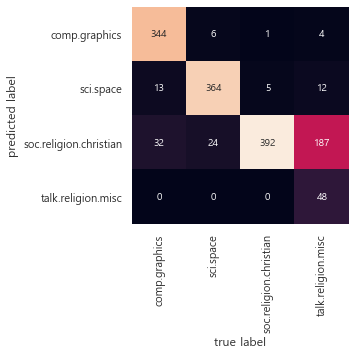

In [27]:
from sklearn.metrics import confusion_matrix 
mat = confusion_matrix(test.target, labels) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=train.target_names, yticklabels=train.target_names) 
plt.xlabel('true label') 
plt.ylabel('predicted label');

### 새로운 값(text)를 예측해보자

In [28]:
train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [29]:
model.predict(['I am a robot cop.'])
y_pred = model.predict(['I am a robot cop.'])
train.target_names
train.target_names[y_pred[0]]

array([2], dtype=int64)

['comp.graphics', 'sci.space', 'soc.religion.christian', 'talk.religion.misc']

'soc.religion.christian'

### 예측 반복작업을 함수로 만들어

In [30]:
def predict_category(s, train=train, model=model): 
    pred = model.predict([s]) 
    return train.target_names[pred[0]]

Let's try it out:

In [31]:
predict_category('sending a payload to the ISS')

predict_category('discussing islam vs atheism')

predict_category('determining the screen resolution')

'sci.space'

'soc.religion.christian'

'comp.graphics'

##  <font color='red'> 각 단어의 빈도로 예측이 거의 완벽
### 모든 naive algorithm은 대용량 high-dimensional text 자료에 잘 사용할 경우 언비리버블하게 잘 예측한다

## 데이터의 특성에 따라 예측을 잘하는 알고리즘이 있음

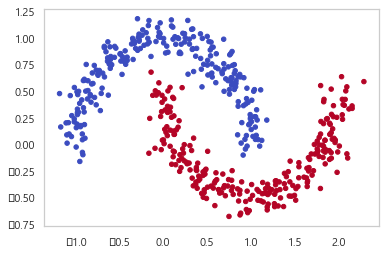

In [32]:
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons
X, y = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm');

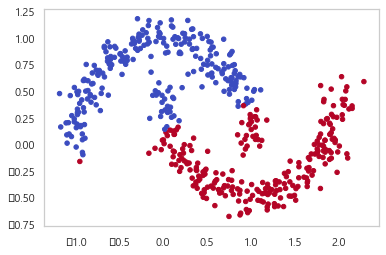

In [33]:
model = GaussianNB()                # 1. 모델 객체화 (max_iter --> aka epochs)
model.fit(X, y)                                      # 2. 학습하기 
y_pred = model.predict(X) # 
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=20, cmap='coolwarm');

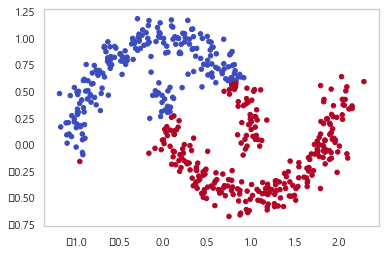

In [34]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(max_iter=1000)                  # 1. 모델 객체화 (max_iter --> aka epochs)
model.fit(X, y)                                      # 2. 학습하기 
y_pred = model.predict(X) # 
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=20, cmap='coolwarm');

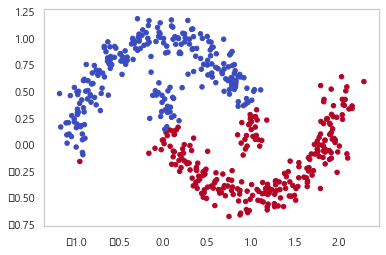

In [35]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0).fit(X, y)                                    # 2. 학습하기 
y_pred = model.predict(X) # 
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=20, cmap='coolwarm');

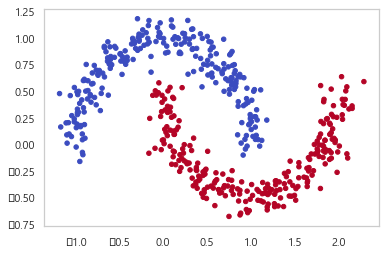

In [36]:
from sklearn.svm import SVC 
model = SVC(kernel='rbf')
model.fit(X, y)
y_pred = model.predict(X) # 
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=20, cmap='coolwarm');

# END